## Analyze A/B Test Results

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.nunique()['user_id']

290584

d. The proportion of users converted.

In [5]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
count_treatment_old_page = ((df['group'] == 'treatment') & (df['landing_page'] == 'old_page')).sum() 
count_control_new_page = ((df['group'] == 'control') & (df['landing_page'] == 'new_page')).sum()
count_treatment_old_page + count_control_new_page

3893

f. Do any of the rows have missing values?

In [7]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# create 2 masks to mask the df so we can have df with consistant group and landin page
mask1 = (df['group'] == 'treatment') & (df['landing_page'] == 'new_page')
mask2 = (df['group'] == 'control') & (df['landing_page'] == 'old_page')
df2 = df[(mask1) | (mask2)]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2['user_id'].duplicated()].index[0]

2893

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop([2893], axis = 0)

In [14]:
# check that the duplicate row is removed
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted


In [15]:
# douple check that the duplicate row is removed
df2['user_id'].shape[0] == df2['user_id'].nunique()

True

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_conv_rate = df2[(df2['converted'] == 1) & (df2['group'] == 'control')].shape[0] / df2[df2['group'] == 'control'].shape[0]
control_conv_rate

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_conv_rate = df2[(df2['converted'] == 1) & (df2['group'] == 'treatment')].shape[0] / df2[df2['group'] == 'treatment'].shape[0]
treatment_conv_rate

0.11880806551510564

In [19]:
# calculate the actual difference (obs_diff) between the conversion rates for the two groups.
# this will be used later
obs_diff = treatment_conv_rate - control_conv_rate
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page'] == 'new_page'].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

till this point, we do not have sufficient evidence to support or reject that the new page will lead to more conversions. i.e. we don't have enough information to determine that.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Null hypothesis $H{o}$:   $p_{new}$  -  $p_{old}$ $\leq$  0** 

**Alternative hypothesis $H{1}$:   $p_{new}$ - $p_{old}$ $\gt$ 0** 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [23]:
n_new = (df2['landing_page'] == 'new_page').sum()
n_new

145310

d. What is $n_{old}$?

In [24]:
n_old = (df2['landing_page'] == 'old_page').sum()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new, p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old, p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
new_page_converted.mean() - old_page_converted.mean()

-0.0006625690072700613

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p = [1 - p_new, p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, p = [1 - p_old, p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

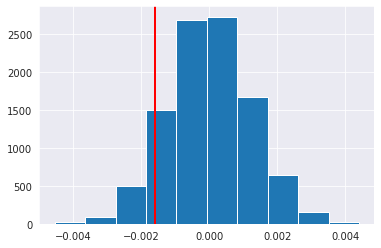

In [29]:
sns.set_style("darkgrid")
plt.hist(p_diffs);
plt.axvline(x = obs_diff, linewidth = 2 , color = 'r');


**Yes it was expected to have a normal distribution of the difference in means because of the central limit theorem**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
# calculate the p value for one tailed test
(p_diffs > obs_diff).mean()

0.9087

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

- **we computed the proportion of the sample data that is greater than the actual difference in means**  
- **The computed value is called p-value**     
- **This means that the p-value is large enough (greater than alpha) which suggests that the difference in conversion rate for new page and old page was not statistically significant hence we fail to reject the null hypothesis**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[df2['landing_page'] == 'old_page']['converted'].sum()
# number of conversions with the new_page
convert_new = df2[df2['landing_page'] == 'new_page']['converted'].sum()
# number of individuals who were shown the old_page
n_old = n_old
# number of individuals who received new_page
n_new = n_new


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_test, p_value =sm.stats.proportions_ztest(count = [convert_new, convert_old], nobs = [n_new, n_old],alternative = 'larger')
print("Z test score: ",z_test)
print("P Value: ",p_value)


Z test score:  -1.3109241984234394
P Value:  0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

- **The z score computed means that a data point is 1.31 standard deviations below the population mean. for hypothesis testing the z score computed is less than $Z_{0.05}$ = 1.645 for an upper tailed test, which suggests that we fail to reject the null hypothesis. regarding the p-values it means that the propability that our data occured under the null hypothesis is 0.905 which is almost identical to the one computed above (in part j)** 

- **The findings of the result of the z-test agree with the findings in j and k as explained**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**We should use logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# create the intercept
df2['inter'] = 1
# create ab_page column dummy variable
df2['ab_page'] = df2['group'].apply(lambda x : 1 if (x == 'treatment') else 0)
# checking the head of df2 
df2.head()

,user_id,timestamp,group,landing_page,converted,inter,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
# Instantiate the model
# using converted as the target varible and inter,ab_page
logistc_model = sm.Logit(df2['converted'], df2[['inter','ab_page']])
result = logistc_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-30 20:00 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
inter        -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

- **The p value found is 0.1899**
- **The p value is diffrent than the one computed in partII becuase of how the null and alternetive hypotheses is set hence the way we calculate the p value.**
   - in partII the hypotheses is set as follows:   
       - **Null hypothesis $H{o}$:  $ $$p_{new}$$  -  $$p_{old}$$ $ $\leq$  0**  
       - **Alternative hypothesis $H{1}$:  $ $$p_{new}$$ - $$p_{old}$$ $ $\gt$ 0**       
       
     which means that it is a one-tailed test
     
     
   - in the logistic regression model the hypotheses is set as follows:   
       - **Null hypothesis $H{o}$:  $ $$p_{new}$$  -  $$p_{old}$$ = 0 $** 
       - **Alternative hypothesis $H{1}$: $  $$p_{new}$$ - $$p_{old}$$ $ $\neq$ 0** 
       
     which means that it is a two-tailed test
   

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more variables have advantages and also disadvantages to your model, regarding the advantages, adding more feature could make your model better, and by increasing the accuracy of the prediction or making the model able to explain a huge percentage of the problem the model trying to solve. on the other hand, this could lead to increase model complexity with no performance improvement also interpret the coefficients hard (in the case of higher-order terms like interaction, square ... etc).**
**All of the above is dependent on if the feature is relevant to the problem at hand or not, finally let's not forget that we deal with the need to study the variable we want to add very well and then test the model with the new feature and then iterate the process if needed.**


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,inter,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [37]:
# eplore the unique values of country column to create the dummy varibles
df_new['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [38]:
### Create the necessary dummy variables
df_new[['CA', 'UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,inter,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [39]:
# Instantiate the model
# using converted as the target varible and inter, CA, UK as features
# note : US will be the baseline
logistc_model = sm.Logit(df_new['converted'], df_new[['inter','CA','UK']])
result = logistc_model.fit();

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [40]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2022-03-30 20:00 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
--------------------------------------------------------------------
          Coef.    Std.Err.       z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
inter    -1.9967     0.0068   -292.3145   0.0000   -2.0101   -1.9833
CA       -0.0408     0.0269     -1.5178   0.1291   -0.0935    0.0119
UK        0.0099     0.0133      0.7458   0.4558   -0.0161    0.0360
==================================================================

"""

**The country had no impact on conversion rates because if you compare the summary of the fitted models there is no change in pseudo-R-squared which tells us the percentage of the problem that can be explained by our model as well as the p values for 'CA' and 'UK' indicates that these variables are not statistically significant for predicting whether the customer will convert or not**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
### Fit Your Linear Model And Obtain the Results
df_new['UK_ab_page'] = df_new['ab_page'] * df_new['UK']
df_new['CA_ab_page'] = df_new['ab_page'] * df_new['CA']

logistc_full_model = sm.Logit(df_new['converted'], df_new[['inter','CA','UK','ab_page','UK_ab_page','CA_ab_page']])
result = logistc_full_model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-30 20:00 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
inter        -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
==================================================================

"""

**The Interaction between country and page had no impact on conversion rates because if you compare the summary of the fitted models there is no change in pseudo-R-squared which tells us the percentage of the problem that can be explained by our model as well as the p values for the Interaction terms'CA_ab_page', and 'UK_ab_page' indicates that these variables are not statistically significant for predicting whether the customer will convert or not to make things even worse it made the interpretation of the coefficient difficult. this is a clear example of what we talked about above regarding the advantages and disadvantages of adding more variables to the model**

### Finally, after the analysis was conducted we do not have sufficient evidence to support the alternative hypothesis hence we fail to reject the null hypothesis, that it is not practical to implement the new page while its conversion rate is equal to or less than that of the old page